In [1]:
pip install pandas scikit-learn nltk matplotlib seaborn jupyter

  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 1.3 MB/s eta 0:00:02
   -------------- ------------------------- 0.8/2.2 MB 1.2 MB/s eta 0:00:02
   ------------------- -------------------- 1.0/2.2 MB 1.2 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 1.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.6/2.2 MB 1.2 MB/s eta 0:00:01
   --------------------------------- ------ 1.8/2.2 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 1.2 MB/s eta 0:00:00
Using cached jsonpointer-3.0.0-py2.py3-none-any.whl (7.6 kB)
  Attempting uninstall: comm
    Found existing installation: comm 0.1.2
    Uninstalling comm-0.1.2:
      Successfully uninsta


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91798\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91798\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of rows you want to read
sample_size = 100000 

# Load only the first 100,000 rows of the dataset
df = pd.read_csv('complaints.csv', nrows=sample_size) 

# --- The rest of the code from Step 1 stays the same ---

# Focus on the necessary columns
df = df[['Product', 'Consumer complaint narrative']]
df = df.dropna() 

# Define the categories we are interested in
categories = [
    "Credit reporting, credit repair services, or other personal consumer reports",
    "Debt collection",
    "Consumer Loan",
    "Mortgage"
]

# Filter the DataFrame to include only these categories
df = df[df['Product'].isin(categories)]

# Check the class distribution
print("Class distribution before renaming:")
print(df['Product'].value_counts())

# Simplify the main category name for easier handling
df['Product'] = df['Product'].replace({
    "Credit reporting, credit repair services, or other personal consumer reports": "Credit reporting, repair, or other"
})

df

Class distribution before renaming:
Product
Credit reporting, credit repair services, or other personal consumer reports    1029
Debt collection                                                                  814
Mortgage                                                                         224
Consumer Loan                                                                     18
Name: count, dtype: int64


,Product,Consumer complaint narrative
67,"Credit reporting, repair, or other",These are not my accounts.
636,"Credit reporting, repair, or other","I wrote three requests, the unverified account..."
836,"Credit reporting, repair, or other",I paid off my Synchrony Lowes account. After t...
888,"Credit reporting, repair, or other",I've found that my credit report has erroneous...
1019,Debt collection,RE : Attentively review my formal writ compose...
...,...,...
99833,Debt collection,"Per TEXAS DEBT COLLECTION ACT, TEX. FIN. CODE ..."
99841,"Credit reporting, repair, or other","I, XXXX XXXX am a victim of Fraud/Identity the..."
99875,Mortgage,"Our mortgage company, Loan Depot, sent us an u..."
99977,"Credit reporting, repair, or other",In accordance with the FAIR CREDIT REPORTING A...


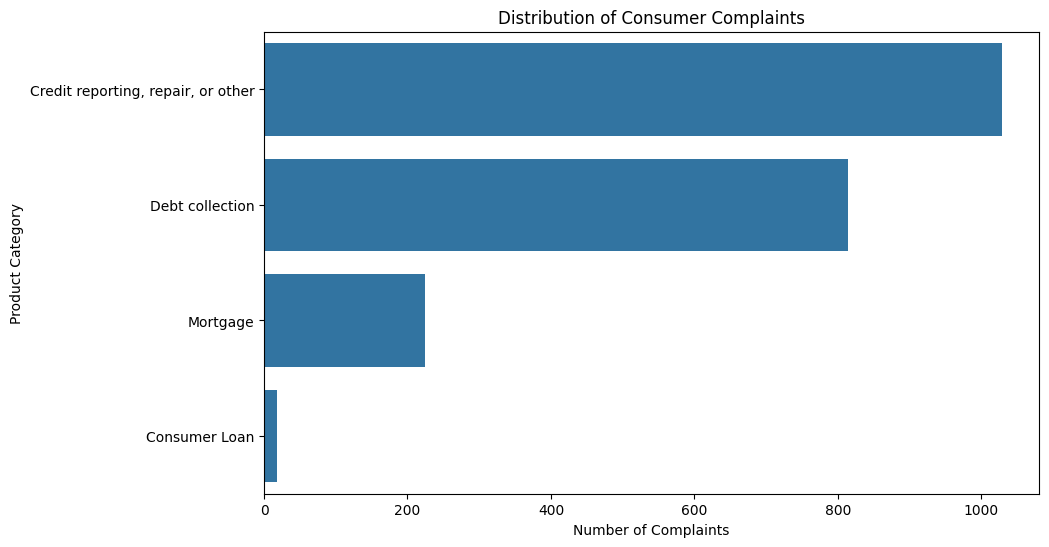

In [7]:
# Plot the distribution of complaints
plt.figure(figsize=(10, 6))
sns.countplot(y='Product', data=df, order=df['Product'].value_counts().index)
plt.title('Distribution of Consumer Complaints')
plt.xlabel('Number of Complaints')
plt.ylabel('Product Category')
plt.show()

In [8]:
# Create a mapping from product category to a numerical ID
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

print("\nCategory to ID Mapping:")
print(category_to_id)


Category to ID Mapping:
{'Credit reporting, repair, or other': 0, 'Debt collection': 1, 'Mortgage': 2, 'Consumer Loan': 3}


In [9]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. To lowercase
    text = text.lower()
    # 2. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # 3. Remove stop words and perform lemmatization
    words = text.split()
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

# Apply the preprocessing function to our complaint narratives
df['processed_narrative'] = df['Consumer complaint narrative'].apply(preprocess_text)

print("\nOriginal vs. Processed Text:")
print("Original:", df['Consumer complaint narrative'].iloc[0])
print("Processed:", df['processed_narrative'].iloc[0])


Original vs. Processed Text:
Original: These are not my accounts.
Processed: account


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Define features (X) and target (y)
X = df['processed_narrative']
y = df['category_id']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# We will use Pipelines to chain the vectorizer and classifier
# This is a best practice to prevent data leakage

# Model 1: Logistic Regression
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))),
    ('clf', LogisticRegression(random_state=42)),
])

# Model 2: Multinomial Naive Bayes
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))),
    ('clf', MultinomialNB()),
])

# Model 3: Linear Support Vector Machine
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))),
    ('clf', LinearSVC(random_state=42)),
])

# List of models to train
pipelines = [logreg_pipeline, nb_pipeline, svc_pipeline]

In [15]:
from sklearn.metrics import accuracy_score, classification_report

model_performance = {}

for pipe in pipelines:
    model_name = pipe.steps[-1][1].__class__.__name__
    print(f"--- Training {model_name} ---")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=id_to_category.values())
    
    model_performance[model_name] = accuracy
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("-" * 50)

# Compare accuracies
print("\n--- Model Accuracy Comparison ---")
for model, acc in model_performance.items():
    print(f"{model}: {acc:.4f}")

--- Training LogisticRegression ---


D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8585
Classification Report:
                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.84      0.93      0.88       206
                   Debt collection       0.88      0.80      0.84       163
                          Mortgage       0.90      0.80      0.85        45
                     Consumer Loan       0.00      0.00      0.00         3

                          accuracy                           0.86       417
                         macro avg       0.65      0.63      0.64       417
                      weighted avg       0.85      0.86      0.85       417

--------------------------------------------------
--- Training MultinomialNB ---


D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8489
Classification Report:
                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.83      0.95      0.88       206
                   Debt collection       0.86      0.80      0.83       163
                          Mortgage       0.97      0.62      0.76        45
                     Consumer Loan       0.00      0.00      0.00         3

                          accuracy                           0.85       417
                         macro avg       0.66      0.59      0.62       417
                      weighted avg       0.85      0.85      0.84       417

--------------------------------------------------
--- Training LinearSVC ---
Accuracy: 0.8585
Classification Report:
                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.84      0.91      0.87       206
                   Debt collection       0.88      0.82      0.84       163
  

D:\anaconda3\envs\tf\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and bein

In [16]:
# Use the best pipeline (LinearSVC) for prediction
def predict_complaint_category(text):
    processed_text = preprocess_text(text)
    prediction_id = pipelines[2].predict([processed_text])[0]
    return id_to_category[prediction_id]

# Example new complaint
new_complaint = "I am having issues with my mortgage payment. The bank charged me an incorrect fee and it has negatively affected my credit score."

predicted_category = predict_complaint_category(new_complaint)
print(f"\nNew Complaint: '{new_complaint}'")
print(f"Predicted Category: {predicted_category}")

# Another example
new_complaint_2 = "A debt collector keeps calling me for a debt that I do not owe. They are harassing me at my workplace."
predicted_category_2 = predict_complaint_category(new_complaint_2)
print(f"\nNew Complaint: '{new_complaint_2}'")
print(f"Predicted Category: {predicted_category_2}")


New Complaint: 'I am having issues with my mortgage payment. The bank charged me an incorrect fee and it has negatively affected my credit score.'
Predicted Category: Mortgage

New Complaint: 'A debt collector keeps calling me for a debt that I do not owe. They are harassing me at my workplace.'
Predicted Category: Debt collection


In [19]:
# Save the sampled and cleaned DataFrame to a new file
df.to_csv('complaints_sample.csv', index=False)